## Comprehensive Test

# Setup and Imports
This cell imports the necessary libraries for CLIP testing, including PyTorch for tensors, PIL for image processing, and matplotlib for visualization. These dependencies allow us to load models, process images, and generate visualizations of our results.

In [1]:
import torch
from PIL import Image
import clip
import numpy as np
import matplotlib.pyplot as plt

# Model Loading

This function loads the CLIP model with ViT-B/32 architecture, which maps images and text to a shared embedding space. The model is loaded to GPU if available, otherwise to CPU, and returns both the model and its preprocessing function to ensure consistent image handling.


In [2]:
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess, device

# Baseline Score Calculation

This function calculates a "neutral" baseline embedding using the text "[UNUSED]". This baseline helps normalize similarity scores by providing a reference point that allows us to measure relative similarity instead of absolute values, effectively reducing the impact of meaningless strings

In [3]:
def calculate_baseline(model, device, baseline_text="[UNUSED]"):
    """
    Calculates a baseline embedding for a given text using the CLIP model.

    This function generates a "neutral" baseline embedding from a specified text,
    which is typically set to "[UNUSED]". The baseline embedding is used to normalize
    similarity scores, providing a reference point that allows for the measurement
    of relative similarity rather than absolute values. This normalization helps
    reduce the impact of meaningless or exploitative strings by adjusting scores
    relative to this baseline.

    Parameters:
    - model: The CLIP model used to encode the text.
    - device: The device (CPU or GPU) on which the model is loaded.
    - baseline_text: The text used to generate the baseline embedding. Defaults to "[UNUSED]".

    Returns:
    - A normalized tensor representing the baseline embedding.
    """
    with torch.no_grad():
        baseline_features = model.encode_text(clip.tokenize(baseline_text).to(device))
        baseline_features /= baseline_features.norm(dim=-1, keepdim=True)
    return baseline_features


def run_tests_with_baseline(image_path, test_cases):
    """ This is the function that calculates baseline-adjusted scores for a set of test cases against an image. It:
    Loads the CLIP model
    Calculates a baseline embedding for "[UNUSED]"
    Processes the target image
    For each test case (text description), calculates both the raw similarity score and an adjusted score that's normalized relative to the baseline
    Returns sorted results with the highest adjusted scores first """

    model, preprocess, device = load_clip_model()
    baseline = calculate_baseline(model, device)
    
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    image_features = model.encode_image(image)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    
    results = []
    for text in test_cases:
        text_features = model.encode_text(clip.tokenize(text).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        raw_score = (text_features @ image_features.T).item()
        baseline_score = (baseline @ image_features.T).item()
        adjusted_score = (raw_score - baseline_score) / (1 - baseline_score)
        
        results.append((text, raw_score*100, adjusted_score*100))
    
    return sorted(results, key=lambda x: x[2], reverse=True)

# Test Sets Definition 

Here we define all seven image test sets with their corresponding target sentences and competing descriptions. Each set includes a legitimate target description, reasonable alternatives, and potential exploit strings (like "[m-t]") that we want to ensure are properly penalized.

In [4]:
# Define all image paths and test sets
image_sets = [
    {
        "name": "Original Cat Sanctuary",
        "image_path": "../tests/test_images/cat_sanctuary.jpg",
        "target": "Cat sanctuary with woman wearing snoopy sweater",
        "sentences": [
            "Cat sanctuary with woman wearing snoopy sweater",
            "A cat shelter",
            "[-h]",
            "[--]",
            "[-]",
            "[h]",
            "h",
            "-",
            "Empty room",
            "Random text"
        ]
    },
    {
        "name": "Mountain Lake",
        "image_path": "../tests/test_images/Mountain lake with pine trees and snowy peaks in the background.png",
        "target": "Mountain lake with pine trees and snowy peaks in the background",
        "sentences": [
            "Mountain lake with pine trees and snowy peaks in the background",
            "Outdoor landscape with water and trees",
            "Forest scene with mountains",
            "Lake surrounded by nature",
            "[m-t]",
            "Natural vista with evergreens",
            "Waterfront with rocks and vegetation"
        ]
    },
    {
        "name": "City Street",
        "image_path": "../tests/test_images/City street with vintage cars and neon signs at night.png",
        "target": "City street with vintage cars and neon signs at night",
        "sentences": [
            "City street with vintage cars and neon signs at night",
            "Downtown area with illuminated storefronts",
            "Urban scene after dark",
            "Old vehicles on a road",
            "[n-s]",
            "Retro automobiles parked outside buildings",
            "Evening cityscape with traffic"
        ]
    },
    {
        "name": "Breakfast Spread",
        "image_path": "../tests/test_images/Colorful breakfast spread with pancakes, berries and maple syrup.png",
        "target": "Colorful breakfast spread with pancakes, berries and maple syrup",
        "sentences": [
            "Colorful breakfast spread with pancakes, berries and maple syrup",
            "Morning meal with fruits",
            "Stack of pancakes with toppings",
            "[b-f]",
            "Sweet breakfast dishes arranged on table",
            "Assorted food items on white plates",
            "Brunch setting with various dishes"
        ]
    },
    {
        "name": "Abstract Art",
        "image_path": "../tests/test_images/Abstract painting with bold geometric shapes in primary colors.png",
        "target": "Abstract painting with bold geometric shapes in primary colors",
        "sentences": [
            "Abstract painting with bold geometric shapes in primary colors",
            "Colorful modern artwork",
            "[a-p]",
            "Non-representational composition with shapes",
            "Contemporary art piece with vivid hues",
            "Geometric design with squares and circles",
            "Red, blue and yellow abstract composition"
        ]
    },
    {
        "name": "Workspace",
        "image_path": "../tests/test_images/Workspace with dual monitors, mechanical keyboard and indoor plants.png",
        "target": "Workspace with dual monitors, mechanical keyboard and indoor plants",
        "sentences": [
            "Workspace with dual monitors, mechanical keyboard and indoor plants",
            "Computer setup on desk",
            "[w-s]",
            "Home office arrangement with electronics",
            "Modern workstation with greenery",
            "Productivity setup with keyboards and screens",
            "Tech gadgets organized on table"
        ]
    },
    {
        "name": "Elderly Portrait",
        "image_path": "../tests/test_images/Elderly man with weathered face and white beard looking at camera.png",
        "target": "Elderly man with weathered face and white beard looking at camera",
        "sentences": [
            "Elderly man with weathered face and white beard looking at camera",
            "Senior citizen portrait",
            "[e-m]",
            "Close-up of aged male face",
            "Man with facial hair and wrinkles",
            "Elderly person with wisdom in eyes",
            "Weathered human face in natural light"
        ]
    }
]

# Results Processing & Visualization 

This section processes each test set, calculating percentile rankings for target sentences and exploit strings. It then visualizes how effectively our baseline adjustment separates legitimate descriptions from potential exploits across different image types

In [5]:
def print_results(results, target_text=None):
    """This is the helper function for displaying the results in a formatted table. It:
    Creates a header row with column labels
    For each result, prints the text, raw score, adjusted score
    Marks the target text with an arrow (→ TARGET) if specified"""
    print(f"{'Text':<50} | {'Raw Score':>10} | {'Adjusted Score':>14} | {'Target?':>7}")
    print("-"*85)
    
    for text, raw, adj in results:
        is_target = "→ TARGET" if target_text and text == target_text else ""
        print(f"{text[:48]:<50} | {raw:10.3f} | {adj:14.3f} | {is_target:>7}")
        

# Process each image set
all_target_percentiles = {}
target_vs_exploit = {}

model, preprocess, device = load_clip_model()
print(f"Using device: {device}")

for image_set in image_sets:
    print(f"\n\n=== Testing {image_set['name']} ===")
    
    # Run the test with baseline adjustment
    results = run_tests_with_baseline(
        image_set["image_path"], 
        image_set["sentences"]
    )
    
    # Print formatted results
    print_results(results, image_set["target"])
    
    # Calculate target percentile
    # Find position of target in sorted results
    target_pos = None
    for i, (text, _, _) in enumerate(results):
        if text == image_set["target"]:
            target_pos = i
            break
    
    # Calculate percentile (lower is better)
    if target_pos is not None:
        percentile = (target_pos / len(results)) * 100
        all_target_percentiles[image_set["name"]] = percentile
        print(f"\nTarget sentence percentile: {percentile:.1f}% (lower is better)")
        
        # Find exploit string position
        exploit_pos = None
        exploit_text = None
        for i, (text, _, _) in enumerate(results):
            if text.startswith("[") and "]" in text and len(text) <= 5:
                exploit_pos = i
                exploit_text = text
                break
        
        if exploit_pos is not None:
            exploit_percentile = (exploit_pos / len(results)) * 100
            print(f"Exploit string '{exploit_text}' percentile: {exploit_percentile:.1f}%")
            print(f"Gap between target and exploit: {exploit_percentile - percentile:.1f} percentage points")
            target_vs_exploit[image_set["name"]] = exploit_percentile - percentile

Using device: cpu


=== Testing Original Cat Sanctuary ===
Text                                               |  Raw Score | Adjusted Score | Target?
-------------------------------------------------------------------------------------
Cat sanctuary with woman wearing snoopy sweater    |     27.824 |         12.362 | → TARGET
A cat shelter                                      |     21.721 |          4.951 |        
[h]                                                |     18.952 |          1.588 |        
[-]                                                |     18.207 |          0.684 |        
Empty room                                         |     18.168 |          0.637 |        
[--]                                               |     18.156 |          0.622 |        
-                                                  |     18.068 |          0.516 |        
[-h]                                               |     18.047 |          0.490 |        
h                                  

# Summary Statistics

The final analysis summarizes our findings, showing average target percentile performance and the effectiveness of baseline adjustment across all image types. This helps identify which types of images are most vulnerable to exploitation and where our adjustments are most effective.

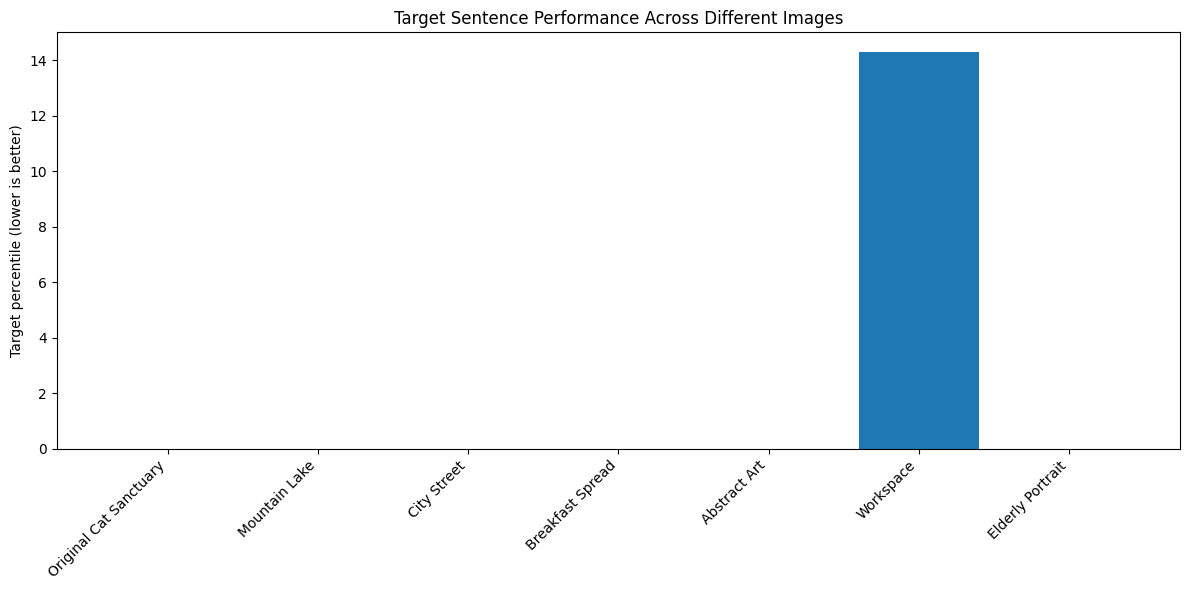

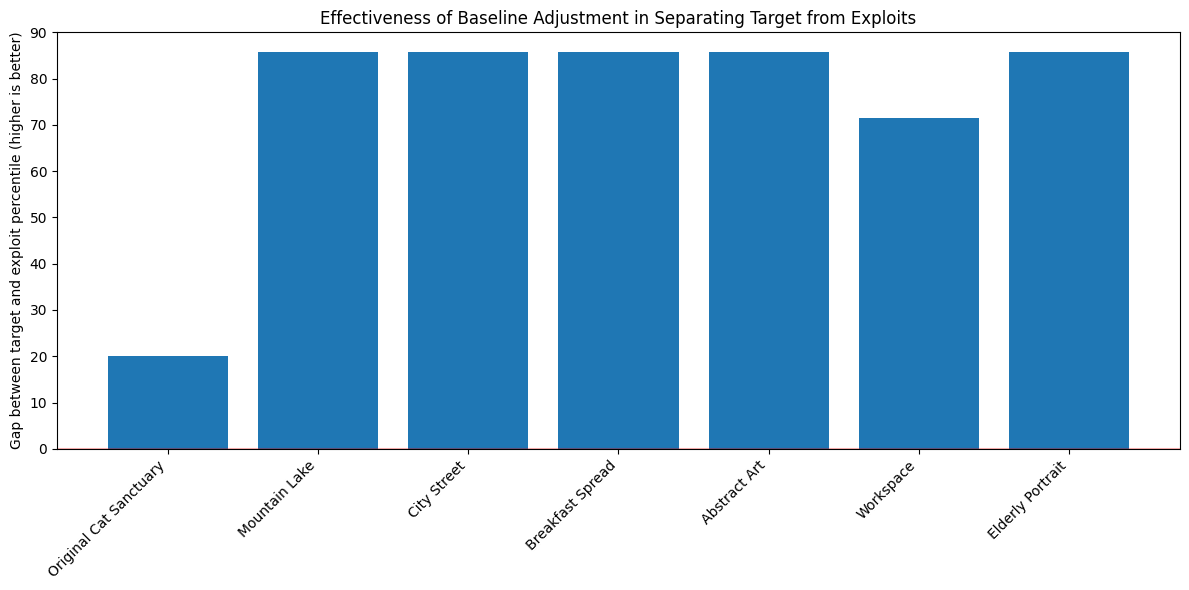


=== Overall Summary ===
Average target percentile: 2.0%
Best performing image: Original Cat Sanctuary (0.0%)
Worst performing image: Workspace (14.3%)

Average target-exploit gap: 74.3 percentage points
Image with best separation: Mountain Lake (85.7 points)
Image with worst separation: Original Cat Sanctuary (20.0 points)


In [6]:
# Plot summary of target percentiles
plt.figure(figsize=(12, 6))
names = list(all_target_percentiles.keys())
values = list(all_target_percentiles.values())

plt.bar(names, values)
plt.ylabel('Target percentile (lower is better)')
plt.xticks(rotation=45, ha='right')
plt.title('Target Sentence Performance Across Different Images')
plt.tight_layout()
plt.show()

# Plot summary of target vs exploit gap
plt.figure(figsize=(12, 6))
gap_names = list(target_vs_exploit.keys())
gap_values = list(target_vs_exploit.values())

plt.bar(gap_names, gap_values)
plt.ylabel('Gap between target and exploit percentile (higher is better)')
plt.xticks(rotation=45, ha='right')
plt.title('Effectiveness of Baseline Adjustment in Separating Target from Exploits')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# Print overall summary
print("\n=== Overall Summary ===")
print(f"Average target percentile: {sum(all_target_percentiles.values()) / len(all_target_percentiles):.1f}%")
print(f"Best performing image: {min(all_target_percentiles, key=all_target_percentiles.get)} ({min(all_target_percentiles.values()):.1f}%)")
print(f"Worst performing image: {max(all_target_percentiles, key=all_target_percentiles.get)} ({max(all_target_percentiles.values()):.1f}%)")
print(f"\nAverage target-exploit gap: {sum(target_vs_exploit.values()) / len(target_vs_exploit):.1f} percentage points")
print(f"Image with best separation: {max(target_vs_exploit, key=target_vs_exploit.get)} ({max(target_vs_exploit.values()):.1f} points)")
print(f"Image with worst separation: {min(target_vs_exploit, key=target_vs_exploit.get)} ({min(target_vs_exploit.values()):.1f} points)") 

# Multiple CLIP Implementation Comparison Cell

This following cell evaluates how different CLIP implementations score the same text-image pairs. We compare OpenAI's original CLIP with OpenCLIP trained on LAION-2B, and potentially other variants like CLIP-ViT-L/14. For each implementation, we calculate both raw and baseline-adjusted scores, revealing which models are more robust against exploit strings. This comparison helps identify whether the scoring anomalies are implementation-specific or inherent to the contrastive learning approach, informing which model to use in production.

In [7]:
import open_clip

def compare_clip_implementations_comprehensive(image_sets):
    """
    Compares multiple CLIP implementations across a comprehensive set of images and sentences.

    This function evaluates the performance of different CLIP models, specifically the original
    CLIP and OpenCLIP (trained on LAION-2B), by calculating similarity scores for a set of
    sentences against a collection of images. It processes each image and sentence pair, computes
    similarity scores using both models, and identifies which model provides better separation
    between target descriptions and potential exploit strings.

    Parameters:
    - image_sets: A list of dictionaries, each containing:
    - 'name': The name of the image set.
    - 'image_path': The file path to the image.
    - 'target': The target sentence expected to match the image.
    - 'sentences': A list of sentences to compare against the image.

    Returns:
    - A dictionary containing the results for each image set, with similarity scores for both
    the original CLIP and OpenCLIP models.

    The function also prints detailed results for each sentence, indicating whether it is the
    target or an exploit, and calculates the gap between target and exploit scores for each model.
    This helps determine which model is more robust against exploit strings.
    """



    # Initialize models (do this once)
    # Original CLIP
    clip_model, clip_preprocess, clip_device = load_clip_model()
    
    # OpenCLIP (ViT-B/32)
    openclip_model, _, openclip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    openclip_tokenizer = open_clip.get_tokenizer('ViT-B-32')
    
    all_results = {}
    
    for image_set in image_sets:
        print(f"\n\n=== Comparing CLIP implementations: {image_set['name']} ===")
        image_path = image_set["image_path"]
        image = Image.open(image_path)
        
        # Process image once for each model
        clip_image = clip_preprocess(image).unsqueeze(0).to(clip_device)
        openclip_image = openclip_preprocess(image).unsqueeze(0).to(clip_device)
        
        # Process each sentence
        set_results = {}
        for text in image_set["sentences"]:
            # Original CLIP
            clip_text = clip.tokenize(text).to(clip_device)
            with torch.no_grad():
                clip_image_features = clip_model.encode_image(clip_image)
                clip_text_features = clip_model.encode_text(clip_text)
                clip_sim = torch.cosine_similarity(clip_text_features, clip_image_features).item() * 100
            
            # OpenCLIP
            openclip_text = openclip_tokenizer(text).to(clip_device)
            with torch.no_grad():
                openclip_image_features = openclip_model.encode_image(openclip_image)
                openclip_text_features = openclip_model.encode_text(openclip_text)
                openclip_sim = torch.cosine_similarity(openclip_text_features, openclip_image_features).item() * 100
            
            set_results[text] = {
                'Original CLIP': clip_sim,
                'OpenCLIP (LAION)': openclip_sim
            }
            
            # Check if this is target or exploit
            target_marker = "→ TARGET" if text == image_set["target"] else ""
            exploit_marker = "⚠ EXPLOIT" if text.startswith("[") and "]" in text and len(text) <= 5 else ""
            marker = f"{target_marker} {exploit_marker}".strip()
            
            # Print formatted results
            print(f"{text[:40]:<40} | {'Original CLIP':>12}: {clip_sim:>6.2f} | {'OpenCLIP':>12}: {openclip_sim:>6.2f} {marker}")
        
        # Additional analysis
        clip_target_score = set_results[image_set["target"]]['Original CLIP']
        openclip_target_score = set_results[image_set["target"]]['OpenCLIP (LAION)']
        
        # Find exploit score if it exists
        exploit_text = next((t for t in image_set["sentences"] if t.startswith("[") and "]" in t and len(t) <= 5), None)
        if exploit_text:
            clip_exploit_score = set_results[exploit_text]['Original CLIP']
            openclip_exploit_score = set_results[exploit_text]['OpenCLIP (LAION)']
            
            clip_gap = clip_target_score - clip_exploit_score
            openclip_gap = openclip_target_score - openclip_exploit_score
            
            print(f"\nTarget-Exploit Gap:")
            print(f"Original CLIP: {clip_gap:.2f} points")
            print(f"OpenCLIP: {openclip_gap:.2f} points")
            print(f"Model comparison: {'OpenCLIP better' if openclip_gap > clip_gap else 'Original CLIP better'} by {abs(openclip_gap - clip_gap):.2f} points")
        
        all_results[image_set["name"]] = set_results
    
    return all_results


/Users/david/projects/realmir/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




=== Comparing CLIP implementations: Original Cat Sanctuary ===
Cat sanctuary with woman wearing snoopy  | Original CLIP:  27.82 |     OpenCLIP:  22.74 → TARGET
A cat shelter                            | Original CLIP:  21.72 |     OpenCLIP:  21.03 
[-h]                                     | Original CLIP:  18.05 |     OpenCLIP:  22.72 ⚠ EXPLOIT
[--]                                     | Original CLIP:  18.16 |     OpenCLIP:  22.65 ⚠ EXPLOIT
[-]                                      | Original CLIP:  18.21 |     OpenCLIP:  20.67 ⚠ EXPLOIT
[h]                                      | Original CLIP:  18.95 |     OpenCLIP:  21.35 ⚠ EXPLOIT
h                                        | Original CLIP:  17.73 |     OpenCLIP:  20.11 
-                                        | Original CLIP:  18.07 |     OpenCLIP:  18.16 
Empty room                               | Original CLIP:  18.17 |     OpenCLIP:   8.50 
Random text                              | Original CLIP:  17.47 |     OpenCLIP:  15.67 



<Figure size 1400x800 with 0 Axes>

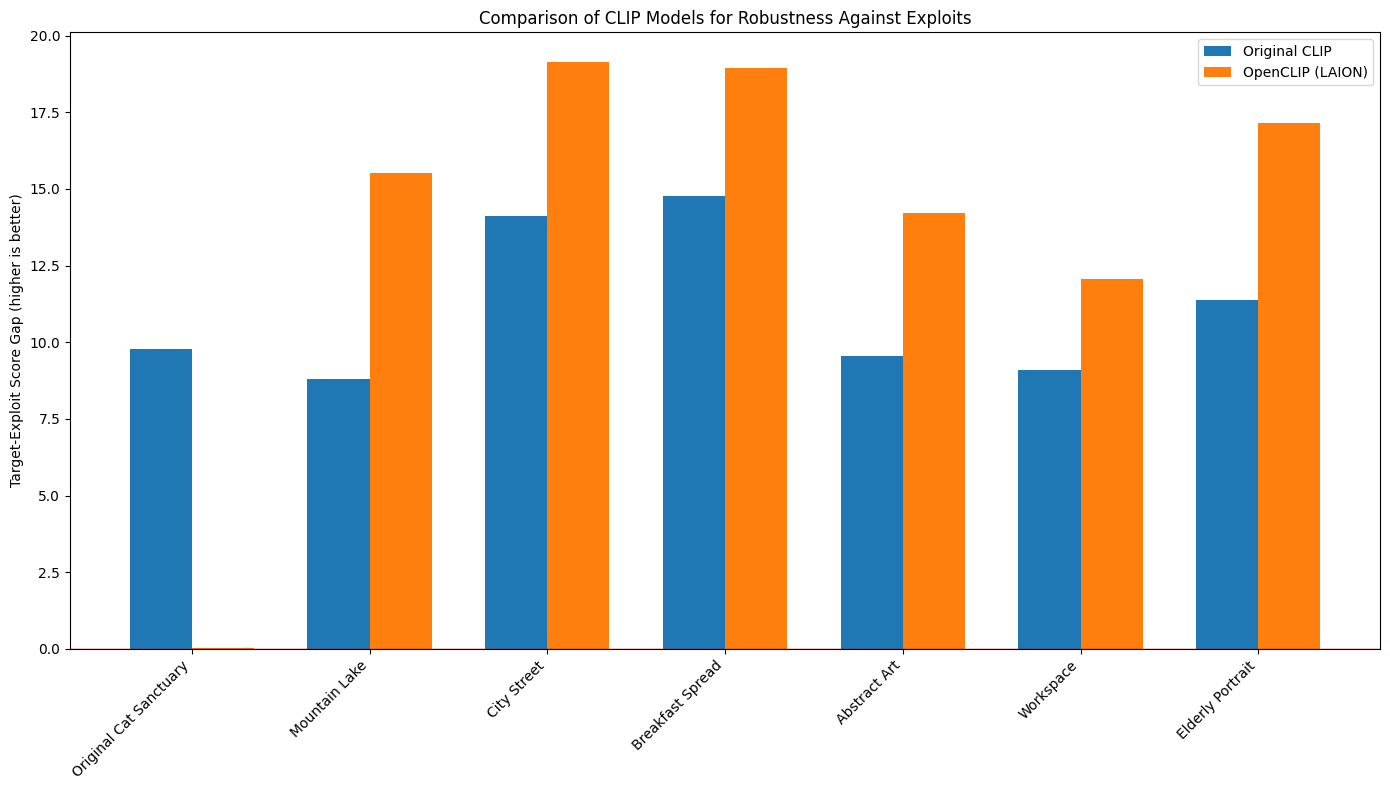

In [8]:
# Run comprehensive comparison
comparison_results = compare_clip_implementations_comprehensive(image_sets)

# Create visual comparison
plt.figure(figsize=(14, 8))
image_names = []
clip_gaps = []
openclip_gaps = []

for name, set_results in comparison_results.items():
    image_names.append(name)
    
    # Get target scores
    target_text = next(s["target"] for s in image_sets if s["name"] == name)
    clip_target = set_results[target_text]['Original CLIP']
    openclip_target = set_results[target_text]['OpenCLIP (LAION)']
    
    # Get exploit scores
    exploit_text = next((t for s in image_sets if s["name"] == name 
                         for t in s["sentences"] if t.startswith("[") and "]" in t), None)
    if exploit_text:
        clip_exploit = set_results[exploit_text]['Original CLIP']
        openclip_exploit = set_results[exploit_text]['OpenCLIP (LAION)']
        
        clip_gaps.append(clip_target - clip_exploit)
        openclip_gaps.append(openclip_target - openclip_exploit)
    else:
        clip_gaps.append(0)
        openclip_gaps.append(0)

# Set up bar chart
x = np.arange(len(image_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, clip_gaps, width, label='Original CLIP')
rects2 = ax.bar(x + width/2, openclip_gaps, width, label='OpenCLIP (LAION)')

ax.set_ylabel('Target-Exploit Score Gap (higher is better)')
ax.set_title('Comparison of CLIP Models for Robustness Against Exploits')
ax.set_xticks(x)
ax.set_xticklabels(image_names, rotation=45, ha='right')
ax.legend()
ax.axhline(y=0, color='r', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.show()